# Image Histograms

Goal of the lecture:
1. Load the RGB sub-region from the previous lecture
1. Convert the data from the original `uint16` type to the `uint8` range
1. Calculate the histogram of each individual band
1. Apply a "Modified Contrast Adjustment"
1. Apply histogram equalization
1. Generate a mask image and visualize overlayed image


## Data loading

Short recap:
- In the previous lecture we downloaded an S2 tile.
- We cut out a smaller region and stored the RGB bands as a compressed numpy archive `npz`.
- The data values themselves were not touched!
    - That means that the data-type is `uint16`.
    - The selected region had no `NO_DATA` values (these are encoded with the value `0`)
        - No need to apply masking

In [1]:
import numpy as np
from simple_downloader import download

# downlaod the sub-image from the previous lecture
# we have stored the bands individually to give them a meaningful name
file_path = download(
    "https://tubcloud.tu-berlin.de/s/i2n2wxEqkPWWYZi/download/sub_rgb_arr.npz", target_dir="data"
)
npzfile = np.load(file_path)
npzfile.files

Target file already exists!
Will skip download. To force download set `force=True`


['red', 'green', 'blue']

In [2]:
channel_names = ["red", "green", "blue"]
rgb_arr = np.stack([npzfile[b] for b in channel_names], axis=-1)
# Reason for this code
assert rgb_arr.shape[-1] == 3

In [3]:
#We want to make sure that none of our values are == 0
assert not (rgb_arr == 0).any(), "There is an unexpected <NO_DATA> value!"
#WE check whether our data in unit16
assert rgb_arr.dtype == np.uint16, "The data is not in the original format anymore!"

## Converting to `uint8`

For our following analysis we are would like the image to be in the `uint8` range [0, 255].
To re-scale the data we have several options.
We could apply a normalization strategy, like min-max-normalization or quantile normalization with rescaling, but we want to keep the data as close as possible to the _original_ data.

To accomplish the re-scaling to `uint8`, we convert the data to the _reflectance_ value, according to the Sentinel-2 documentation.
This will project the data to the range [0, 1]*.
The formulae has _recently_ (January 2022) changed to:

$$ 
\text{reflectance}_i = \frac{\text{DN}_i + \text{Offset}_i}{\text{QuantificationValue}_i}
$$

where:
- $\text{QuantificationValue}_i$ = `10_000` for Sentinel-2 data
    - Can be found in the `MTD_MSIL2A.xml` file under `BOA_QUANTIFICATION_VALUE`
- $\text{DN}_i$ is the digital number that is provided in the JPEG2000 files as a `uint16` value
- $\text{Offset}_i$ is the _newly_ introduced band-offset 
    - Can be found in the `MTD_MSIL2A.xml` file under `BOA_ADD_OFFSET`
    - Often the same value for a given tile (for our tile it is `1_000`)

The details can be found on the [Copernicus Sentinel-2 product update page](https://scihub.copernicus.eu/news/News00931).
For a more general overview of the Sentinel-2 L2A data, see the [Sentinelhub sentinel-L2A documentation](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/).


*) This is not entirely true; the reflectance value can become larger than 1. This is not important for our investigation and we will clamp the values to ensure that the range is actually [0, 1].

### The rabbit hole
As we have seen above, the Sentinel-2 data structure/format is not as easy to work with as other classic computer vision imagery.
For our course it is sufficient to know how to derive the reflectance values from the source data.
The details of the Sentinel-2 data format is a rabbit hole that is not relevant for the contents of the course.
The key point is that the data cannot be nicely visualized without any image processing techniques.

In [4]:
img_float = (rgb_arr + 1_000) / 10_000
# Normalize image between 0 & 1
img_float = np.clip(img_float, 0.0, 1.0)
img = np.uint8(img_float * 255)
img

array([[[66, 62, 59],
        [63, 61, 57],
        [63, 61, 57],
        ...,
        [64, 63, 59],
        [67, 66, 61],
        [72, 69, 65]],

       [[65, 62, 58],
        [64, 61, 58],
        [63, 61, 58],
        ...,
        [68, 65, 61],
        [67, 65, 61],
        [70, 67, 63]],

       [[66, 62, 58],
        [63, 61, 58],
        [64, 61, 58],
        ...,
        [68, 67, 63],
        [67, 65, 60],
        [66, 64, 60]],

       ...,

       [[55, 57, 53],
        [55, 57, 53],
        [55, 57, 53],
        ...,
        [58, 59, 54],
        [62, 60, 56],
        [67, 63, 58]],

       [[56, 58, 53],
        [55, 58, 53],
        [55, 57, 53],
        ...,
        [56, 57, 53],
        [58, 58, 54],
        [61, 60, 56]],

       [[55, 57, 53],
        [55, 57, 53],
        [55, 58, 53],
        ...,
        [57, 58, 54],
        [57, 58, 54],
        [62, 61, 56]]], dtype=uint8)

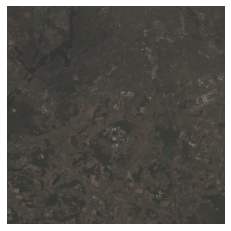

In [5]:
import matplotlib.pyplot as plt

# change default figure size
plt.rcParams["figure.figsize"] = (10, 10)


def imshow(*args, **kwargs):
    """Short wrapper that calls `plt.imshow` with the provided arguments, but turns of the axis"""
    plt.imshow(*args, **kwargs)
    plt.axis("off")


imshow(img)

## Calculating histograms

Question: What is the corect number of bins and the required `range` if we want to have a bin for each brightness value?

In [ ]:
?np.histogram

Answer:
- We have values from 0 -- 255.
- We want to count how often each individual value appears.
- So we have 256 buckets (one for each number)
- The left histogram edge is always inclusive
    - 255 should be left histogram edge of the last bin

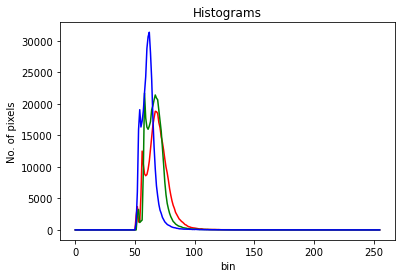

In [6]:
# print RGB histogram
for i, channel in enumerate(channel_names):
    hist, bin_edges = np.histogram(img[:, :, i], bins=256, range=[0, 256])
    assert bin_edges[0] == 0
    assert bin_edges[-2] == 255
    # 256 brightness values => 256 bins
    assert len(hist) == 256
    # using the fact that the channel names are also an accepted color name
    plt.plot(hist, color=channel)
    plt.xlabel("bin")
    plt.ylabel("No. of pixels")
    plt.title("Histograms")

### Modified Contrast Adjustment

In the lecture we have defined:

$$

I_\text{out}[n, m] = \begin{cases}
    0, & \text{if}\ I_\text{in}[m, n] < I_\text{min}' \\
    (2^L - 1) \cdot \frac{I_\text{in}[m, n] - I_\text{min}'}{I_\text{max}' - I_\text{min}'}, & \text{if}\ I_\text{min}' \leq I[m, n] \leq I_\text{max}' \\
    2^L - 1, & \text{if}\ I_\text{in}[n, m] > I_\text{max}'
\end{cases}

$$

where:
- $I_\text{in}[n, m]$ is the input pixel value at the location $[n, m]$
- $I_\text{out}[n, m]$ is the output pixel value at the location $[n, m]$ after applying the modified contrast adjustment method
- $I_\text{min}'$ is the _selected_ minimum target value of the adjusted scale
    - This does _not_ has to be minimum value of the target input image $I$
- $I_\text{max}'$ is the _selected_ maximum target value of the adjusted scale
    - This does _not_ has to be maximum value of the target input image $I$
- $L$ is the number of bits for the discrete brightness values


When working with `uintX` beware of under-/overflow!
One _trick_ is to convert the source data into a different format.
This may be done explicitely by calling `np.int128`, for example, or by adding/substracting float values

In [7]:
#So data can over flow. So we have more data than bits so we can't store everything.
# To further understand, check: https://www.cs.utah.edu/~germain/PPS/Topics/Matlab/uint8.html
A = np.array([0], dtype=np.uint8)
A - 1

array([255], dtype=uint8)

In [8]:
# np.float32(A) - 1
A - 1.0

array([-1.])

In [9]:
# implicitely convert by providing these values as float values
fmin = 51.0
fmax = 110.0

adj_img = 255 * ((img - fmin) / (fmax - fmin))
adj_img.min(), adj_img.max()

(-8.64406779661017, 687.2033898305084)

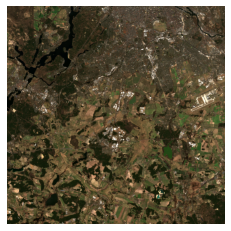

In [10]:
adj_img = np.clip(adj_img, 0, 255)
# convert it back to uint8
adj_img = np.uint8(adj_img)
imshow(adj_img)

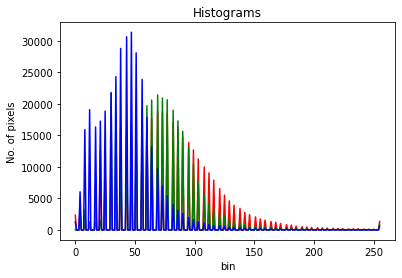

In [11]:
for i, channel in enumerate(channel_names):
    hist, bin_edges = np.histogram(adj_img[:, :, i], 256, range=[0, 256])
    # hist, bin_edges = np.histogram(img[:, :, i], bins=np.arange(257))
    assert bin_edges[0] == 0
    assert bin_edges[-2] == 255
    # 256 brightness values => 256 bins
    assert len(hist) == 256
    # using the fact that the channel names are also an accepted color name
    plt.plot(hist, color=channel)
    plt.xlabel("bin")
    plt.ylabel("No. of pixels")
    plt.title("Histograms")

TODO: Play around with different fmin/fmax values

## Histogram Equalization

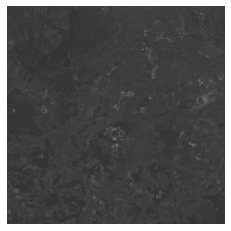

In [12]:
img_B = img[..., 2].copy()
# disable implicit min/max normalization!
imshow(img_B, cmap="gray", vmin=0, vmax=255)

### In-course practice:

- The formulae from the lecture originated from "Remote Sensing Digital Image Analysis -- An Introduction 2013" Ch. 4.4
    - Refer to this chapter for the full derivation of the formulae that is used here

$$ y' = \text{constant} \times C(x) = \frac{L' - 1}{N} \times C(x) = (L' - 1) \cdot C_\text{norm}(x)$$
where:
- $0 \text{--} (L' - 1)$ are the $L$ brightness values available in the image
    - These values do not _have_ to be present in the image
    - For 8-bit images the $L' = 256$
- $N$ is the total number of pixels in the image
- $C(x)$ is the cumulative histogram function (hint: it can be calculated as a cumulative sum)

The values $y'$ must then be converted to discrete integer values.
We use the recommended approach of rounding to the nearest integer value.

a ) plot the cumulative histogram. 

In [20]:
img_B
len(img_B)

600

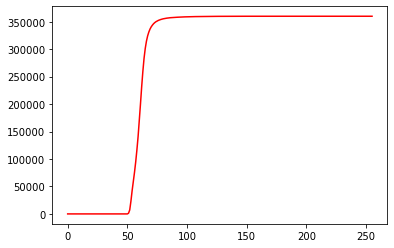

In [14]:
hist_B, hist_edges = np.histogram(img_B, 256, range=[0, 256])
assert hist_edges[0] == 0
assert hist_edges[-2] == 255
assert len(hist_B) == 256
cum_hist_B = hist_B.cumsum()
plt.figure()
plt.plot(cum_hist_B, color="r");

b) calculate the equalized histogram 
<!-- START REMOVAL -->

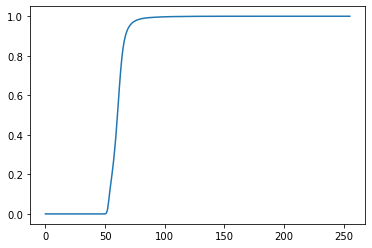

In [15]:
# So we find the the max value for CDF
total_num_pixels = cum_hist_B.max()  # or cdf[-1]
assert cum_hist_B.max() == cum_hist_B[-1]
#C(x)/N -> We normalize the cdf (check formula above)
cdf_norm = cum_hist_B / total_num_pixels
plt.plot(cdf_norm)

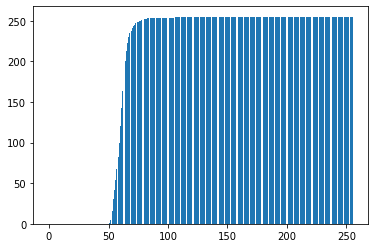

In [16]:
#We equalize the histogram using the formula above
L = 256
y_prime = cdf_norm * (L - 1)
y = np.round(y_prime, decimals=0)

# y is our equalization function
# note that maximum value is 255 and all values are integers
# plot with bar to indicate that the values are discrete
plt.bar(range(len(y)), y);

In [17]:
# We want to make sure that our min is not less than 0 and not max than 255 [0-255]
assert 0 <= y.min()
assert y.max() <= 255

In [19]:
len(y) #So we have 256 values

256

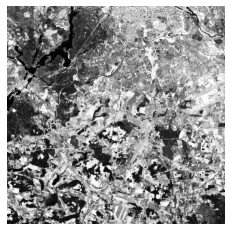

In [24]:
# So we move the value in the range from 0-255. WE initally had 600 values(check above)
img_B_eq = y[img_B]
img_B_eq = np.uint8(img_B_eq)
#imshow(img_B) #To see how the original image looked. THe normalize image has better resolution
imshow(img_B_eq, vmin=0, vmax=255, cmap="gray");

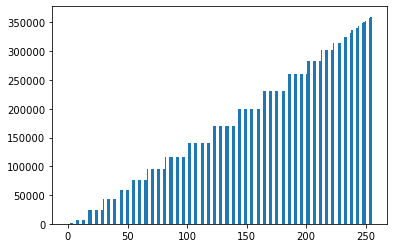

In [25]:
#CDF of new normalize histogram
hist_B_eq, _ = np.histogram(img_B_eq, 256)
c = hist_B_eq.cumsum()
plt.bar(range(len(c)), c, width=0.5);

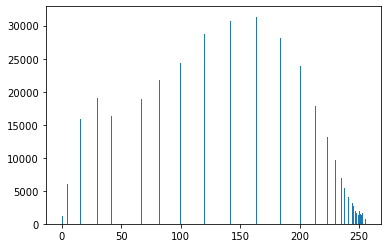

In [26]:
#We can see values are now distributed
plt.bar(range(len(hist_B_eq)), hist_B_eq);

## Image Thresholding

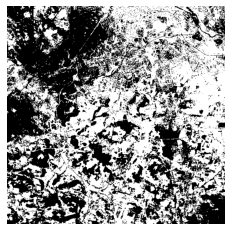

In [28]:
#So we threshold image.This means that image values lesser than 30 goes to0 while other goes to 255
threshold = 130
img_B_eq_thres = np.where(img_B_eq < threshold, 0, 255)

imshow(img_B_eq_thres, cmap="gray", vmin=0, vmax=255)

### In-course practice:
Create a mask from the thresholded image and apply it on the original image and the contrast-adjusted image. 
The final image `img_masked` should be black in the masked out pixels and other pixels representing with their original values (colors).
So values below the previous threshold should become 0 and the values equal/larger than the threshold should stay the same.

In [29]:
s = f"""
{img_B_eq_thres.shape=}
{img.shape=}
"""
print(s)


img_B_eq_thres.shape=(600, 600)
img.shape=(600, 600, 3)



In [30]:
keep_indicator = img_B_eq_thres > 0
keep_indicator

array([[False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

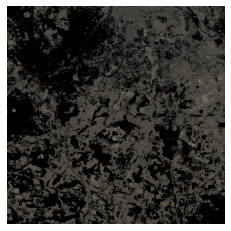

In [31]:
# use ellipses to create new axis at the last dimensionality
# equal to img_B_eq_thres[:, :, np.newaxis]
# https://numpy.org/doc/stable/glossary.html?highlight=ellipses#term-.-.-.
img_masked = np.where(keep_indicator[..., np.newaxis], img, 0)
imshow(img_masked)

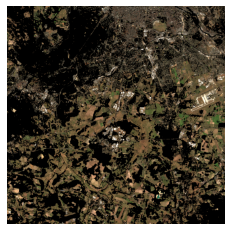

In [32]:
# use previously adjusted histogram image to display the values
adj_img_masked = np.where(keep_indicator[..., np.newaxis], adj_img, 0)
imshow(adj_img_masked)